<a href="https://colab.research.google.com/github/MystEric/Taller_3_Deep_Learning/blob/master/image2image%20cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
from keras.datasets import cifar10
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, UpSampling2D, ZeroPadding2D, BatchNormalization, Conv2DTranspose, ReLU, Concatenate, Dense, Activation, Reshape
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import load_model, Model, Sequential
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image 
from sklearn.metrics import label_ranking_average_precision_score

In [225]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

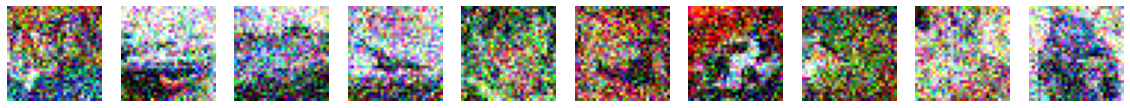

In [226]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
plt.show()

In [227]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)
   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)
   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)
   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
   return Model(dae_inputs, dae_outputs, name='dae')

autoencoder = denoising_autoencoder()
autoencoder.summary()

Model: "dae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dae_input (InputLayer)          [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 16, 16, 32)   896         dae_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_219 (BatchN (None, 16, 16, 32)   128         conv2d_123[0][0]                 
__________________________________________________________________________________________________
re_lu_218 (ReLU)                (None, 16, 16, 32)   0           batch_normalization_219[0][0]    
________________________________________________________________________________________________

In [228]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/20
391/391 [==============================] - 10s 25ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 2/20
391/391 [==============================] - 9s 24ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 3/20
391/391 [==============================] - 9s 24ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 4/20
391/391 [==============================] - 9s 24ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 5/20
391/391 [==============================] - 9s 24ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 6/20
391/391 [==============================] - 9s 23ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 7/20
391/391 [==============================] - 9s 23ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 8/20
391/391 [==============================] - 9s 23ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 9/20
391/391 [==============================] - 9s 24ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 10/20
391/391 [==============================] - 9s 23ms/step - loss: 0.0055 - val_l

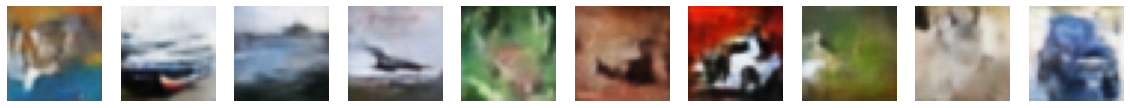

In [229]:
denoised_images=autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 3))
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(denoised_images[i])
    plt.axis('off')
plt.show()

In [230]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=15).output)
encoder.summary()

Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dae_input (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_219 (Bat (None, 16, 16, 32)        128       
_________________________________________________________________
re_lu_218 (ReLU)             (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_220 (Bat (None, 8, 8, 64)          256       
_________________________________________________________________
re_lu_219 (ReLU)             (None, 8, 8, 64)        

In [231]:
def compute_average_precision_score(test_codes, test_labels, learned_codes, y_train, n_samples):
    # For each n_samples (=number of retrieved images to assess) we store the corresponding labels and distances
    out_labels = []
    out_distances = []
    
    #For each query image feature we compute the closest images from training dataset
    for i in range(len(test_codes)):
        distances = []
        # Compute the euclidian distance for each feature from training dataset
        for code in learned_codes:
            distance = np.linalg.norm(code - test_codes[i])
            distances.append(distance)
        # nb_elements = learned_codes.shape[0]
        # learned_code_index = np.arange(nb_elements)
        # Store the computed distances and corresponding labels from training dataset
        distances = np.array(distances)
        # Scoring function needs to replace similar labels by 1 and different ones by 0
        labels = np.copy(y_train)
        bin_labels=[]
        for label in labels:
          if label==test_labels[i]:
            bin_labels.append(1)
          else:
            bin_labels.append(0)
        
        if len(distances)< len(labels):
          n=len(distances)
        else:
          n=len(labels)

        distance_with_labels=[]
        for j in range(n):
          distance_with_labels.append([distances[j],bin_labels[j]])

        distance_with_labels.sort(key=lambda x: x[0])
        
        # The distances are between 0 and 28. The lesser the distance the bigger the relevance score should be
        sorted_distances=[]
        sorted_labels=[]
        # sorted_indexes=[]

        for k in range(len(distance_with_labels)):
          sorted_distances.append(28-distance_with_labels[k][0])
          sorted_labels.append(distance_with_labels[k][1])
          # sorted_indexes.append(distance_with_labels[k][2])

        # We keep only n_samples closest elements from the images retrieved
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])

    # out_labels = np.array(out_labels)
    # out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
    # np.save(out_labels_file_name, out_labels)

    # out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
    # out_distances = np.array(out_distances)
    # np.save(out_distances_file_name, out_distances)
    
    # Score the model based on n_samples first images retrieved
    print('l:', out_labels)
    print('d', out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)

    scores.append(score)
    return score

def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []
    
    for code in learned_codes:
      distance = np.linalg.norm(code - test_code)
      distances.append(distance)
    nb_elements = learned_codes.shape[0]
    learned_code_index = np.arange(nb_elements)
    # Store the computed distances and corresponding labels from training dataset
    distances = np.array(distances)
    # Scoring function needs to replace similar labels by 1 and different ones by 0
    labels = np.copy(y_train)
    bin_labels=[]
    for label in labels:
      if label==test_label:
        bin_labels.append(1)
      else:
        bin_labels.append(0)
        
    if len(distances)< len(labels):
      n=len(distances)
    else:
      n=len(labels)

    distance_with_labels=[]
    for j in range(n):
       distance_with_labels.append([distances[j],bin_labels[j],learned_code_index[j]])

    distance_with_labels.sort(key=lambda x: x[0])
        
    # The distances are between 0 and 28. The lesser the distance the bigger the relevance score should be
    sorted_distances=[]
    sorted_labels=[]
    sorted_indexes=[]

    for k in range(len(distance_with_labels)):
      sorted_distances.append(28-distance_with_labels[k][0])
      sorted_labels.append(distance_with_labels[k][1])
      sorted_indexes.append(distance_with_labels[k][2])

    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = x_test[0]
    plt.imshow(original_image, interpolation='nearest')
    plt.show()
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    plt.figure(figsize=(20, 2))
    plt.imshow(retrieved_images, interpolation='nearest')
    plt.show()


l: [[0, 0, 1, 1, 1, 1, 1, 1, 0, 0]]
d [[4.588735580444336, 3.3177719116210938, 2.1757240295410156, 2.0041141510009766, 1.3521575927734375, 1.0599632263183594, 1.0487041473388672, 0.7811985015869141, 0.1613636016845703, 0.013715744018554688]]
Model score: 0.594047619047619
(10000, 1024)
l: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
d [[9.88075065612793, 8.974445343017578, 8.624738693237305, 8.51075553894043, 8.450540542602539, 8.337837219238281, 8.269041061401367, 8.238351821899414, 8.217512130737305, 8.169801712036133, 7.697793960571289, 7.685174942016602, 7.683053970336914, 7.634315490722656, 7.627748489379883, 7.54115104675293, 7.531042098999023, 7.501312255859375, 7.449871063232422, 7.448017120361328, 7.417196273803711, 7.395256042480469, 7.363304138183594, 7.276115417480469, 7.260072708129883, 7.247993469238281, 7.231132507324219, 7.212856292724609, 7.209466934204102, 7.185

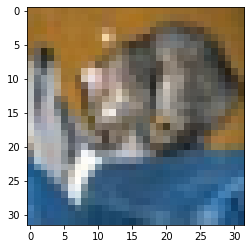

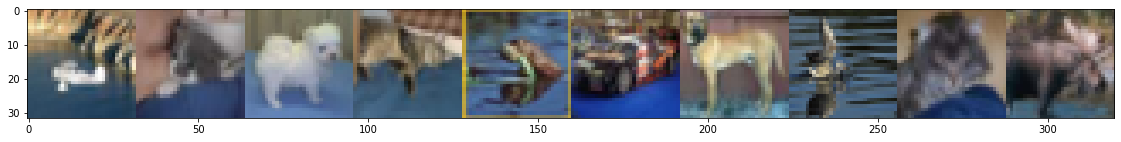

FileNotFoundError: ignored

In [232]:
# Array in which we will store computed scores
scores = []

# In order to save time on computations we keep only 1000 query images from test dataset 
n_test_samples = 1

# Each time we will score the first 10 retrieved images, then the first 50 etc...
n_train_samples = [10, 50]
                  #  100, 200, 300, 400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000,
                  #  20000, 30000]

def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3))
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, y_train, n_train_samples)
    print('Model score:', score)
    
    print(test_codes.shape)

for n_train_sample in n_train_samples:
    test_model(n_test_samples, n_train_sample)
 
retrieve_closest_images(x_test[0],y_test[0])

# Save the computed scores into a file
np.save('computed_data/scores', np.array(scores))